In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import sympy
import os
import pyswarms as ps

import IPython.display as dp
import matplotlib.pyplot as plt
import seaborn as sns

dp.set_matplotlib_formats('retina')
sns.set_style('whitegrid')
sns.despine()

%matplotlib notebook

## Solver

In [2]:
def get_initial_values(P0, Q0, V0, angle0, theta0, Sn=2220, Vn=400, fn=60, Sb=100, Vb=400):
    """
    Initializes generator state vector `x` and network terminal variables vector `V`
    in machine base from given power flow values in system base and angle in radians.
    """
    
    # unpack parameters guess
    
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta0
    
    # define transforms
    
    # vf_MB = vf * Vb / Vn
    wb = 2 * np.pi * fn
    S_SBtoMB = Sb / Sn
    V_MBtoSB = Vn / Vb
    I_MBtoSB = Sn * Vb / (Sb * Vn)
    Z_MBtoSB = Sb * Vn ** 2 / (Sn * Vb ** 2)
    
    # initialize stator quantitites
    
    p0 = P0 / Sb
    q0 = Q0 / Sb
    Vt0 = V0 * np.exp(1j * angle0)
    S0 = p0 - 1j * q0
    I0 = S0 / Vt0.conjugate()
    vr0 = Vt0.real
    vi0 = Vt0.imag
    ir0 = -I0.real
    ii0 = -I0.imag
    
    # initialize DQ-quantities
    
    w0 = 1
    delta0 = np.angle(Vt0 + (ra + 1j * xq) * Z_MBtoSB * I0)
    
    Vdq0 = Vt0 * (1 / V_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    Idq0 = I0 * (1 / I_MBtoSB) * np.exp(1j * (-delta0 + np.pi/2))
    
    vd0 = Vdq0.real
    vq0 = Vdq0.imag
    id0 = Idq0.real
    iq0 = Idq0.imag
    
    # initialize order 3
    
    e1q0 = vq0 + ra * iq0 + x1d * id0
    
    # initialize AVR
    
    v = np.abs(Vt0)
    vref = v
    vs0 = 0
    vm0 = v
    vf0 = (e1q0 + (xd - x1d) * id0) * V_MBtoSB
    vr0 = K0 * (1 - Tavr1 / Tavr2) * (vref + vs0 - vm0)
    
    # initialize PSS
    
    v20 = 0
    
    # constants
    
    pm = (vq0 + ra * iq0) * iq0 + (vd0 + ra * id0) * id0
    vsmin, vsmax = -0.2, 0.2
    vfmin, vfmax = -6.4, 7
    
    # pack values
    
    x = np.array([delta0, w0, v20, vs0, vm0, vr0, vf0, e1q0])
    V = np.array([vd0, vq0, id0, iq0])
    c = np.array([pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, vs0, wb])
    
    return x, V, c, (p0, q0)

In [3]:
def constraint_objective(x, xx, c, S, theta):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    res = np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    return np.linalg.norm(res, 2) ** 2

def constraint_objective2(theta, x, xx, c, S):
    return constraint_objective(x, xx, c, S, theta)

def constraint_jacobian(x, xx, c, S, theta):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    dif = 2 * np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    m = np.array([
        [ra, -x1d, id, -iq],
        [xq, ra, iq, id],
        [(x1d * xq + ra ** 2), 0, vd, vq],
        [0, (x1d * xq + ra ** 2), vq, -vd]
    ])
    
    return m @ dif

def constraint_jacobian2(theta, x, xx, c, S):
    delta, w, v2, vs, vm, vr, vf, e1q = xx
    vd, vq, id, iq = x
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    p, q = S
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    vt = np.sqrt(vd ** 2 + vq ** 2)
    
    dif = 2 * np.array([
        (x1d * xq + ra ** 2) * id - (xq * e1q - xq * vq - ra * vd),
        (x1d * xq + ra ** 2) * iq - (ra * e1q - ra * vq + x1d * vd),
        vd * id + vq * iq - p / 22.2,
        vq * id - vd * iq - q / 22.2
    ])
    
    m = np.array([
        [0, 0, 0, 0],
        [2 * ra * id + vd, 2 * ra * iq - e1q + vq, 0, 0],
        [xq * id, xq * iq - vd, 0, 0],
        [0, 0, 0, 0],
        [x1d * id - e1q + vq, x1d * iq, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]
    ])
    
    return m @ dif

def constraint_solve(x, V, c, S, theta, threshold=1e-16):
    if constraint_objective(V, x, c, S, theta) < threshold:
        return V
    else:
        return minimize(constraint_objective,
                        x0=V,
                        args=(x, c, S, theta),
                        method='L-BFGS-B',
                        jac=constraint_jacobian, bounds=[(0., None)] * 4).x

In [4]:
def transition(x, v, c, theta, tau=1e-4):
    delta, w, v2, vs, vm, vr, vf, e1q = x
    vt, phi = v
    pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
    ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = theta
    
    vd = vt * np.sin(delta - phi)
    vq = vt * np.cos(delta - phi)
    
    id = (xq * e1q - xq * vq - ra * vd) / (x1d * xq + ra ** 2)
    iq = (ra * e1q - ra * vq + x1d * vd) / (x1d * xq + ra ** 2)
    
    p = 22.2 * (vd * id + vq * iq)
    q = 22.2 * (vq * id - vd * iq)
    
    xnew = x + tau * np.array([
        wb * (w - ws),
        ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H),
        Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H) - v2 / Tw,
        (Tpss1 * (Kw * ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id \
                             - KD * (w / ws - 1)) / (2 * H) - v2 / Tw) + v2 - vs) / Tpss2,
        (vt - vm) / Tr,
        (K0 * (1 - Tavr1 / Tavr2) * (vref + vs - vm) - vr) / Tavr2,
        ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / Te,
        (- e1q - (xd - x1d) * id + vf) / T1d0
    ])
    
    xnew[3] = max(vsmin, min(vsmax, xnew[3]))
    xnew[6] = max(vfmin, min(vfmax, xnew[6]))
    
    return xnew, (p, q)

## Learner

In [36]:
class Learner():
    def __init__(self, injections, theta_true, stepsize=None, eta=1., steps=1e2,
                 eps=1e-3, tau=1e-4, mu=1e2, c1=1e-4, c2=1e-1):
        self.injections = injections
        self.theta_true = theta_true
        self.stepsize = stepsize if stepsize is not None else lambda x: 1
        self.steps = steps
        self.eta = eta
        self.eps = eps
        self.tau = tau
        self.mu = mu
        self.c1 = c1
        self.c2 = c2
        
        # ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0
        self.s_ws = 10.
        self.s_ra = 0.01
        self.s_x1d = 1.
        self.s_xd = 10.
        self.s_xq = 10.
        self.s_H = 10.
        self.s_T1d0 = 10.
        self.s_Kw = 10.
        self.s_Tw = 10.
        self.s_Tpss1 = 0.1
        self.s_Tpss2 = 0.1
        self.s_Tr = 0.1
        self.s_Tavr1 = 1.
        self.s_Tavr2 = 1.
        self.s_Te = 0.001
        self.s_K0 = 1000
        
        self.theta = None
        
    def scale(self, x):
        return x # * np.array([10., 0.01, 1., 10., 10., 10., 1., 10., 10., 10., 0.1, 0.1, 0.1, 1., 1., 0.001, 1000])
    
    def unscale(self, x):
        return x # / np.array([10., 0.01, 1., 10., 10., 10., 1., 10., 10., 10., 0.1, 0.1, 0.1, 1., 1., 0.001, 1000])
    
    def load_injection(self):
        fname = np.random.choice(self.injections)
        df = pd.read_csv(fname).drop_duplicates('t').drop(['t'], axis=1)
        df.phi = df.phi * np.pi / 180
        return df[['p', 'q']].values, df[['v', 'phi']].values
        
    def solve(self, src):
        x0, v0, c, pq0 = get_initial_values(P0=1997.9999999936396,
                                           Q0=967.9249699065775,
                                           V0=1.0,
                                           angle0=0.494677176989154,
                                           theta0=self.unscale(self.theta))
        
        xs = [x0]
        vs = [v0]
        pqs = [pq0]
        for t in range(1, len(src)):
            x, pq = transition(xs[-1], src[t], c, self.unscale(self.theta))
            xs.append(x)
            pqs.append(pq)
            
        return xs, pqs, c
    
    def barrier(self):
        rv = np.where(self.theta > 0, - np.log(self.theta), np.inf)
        rv[6] = 0
        return np.sum(rv)
    
    def barrier_grad(self):
        rv = np.where(self.theta > 0, - 1/self.theta, 0)
        rv[6] = 0
        return rv
        
    def objective(self, pqs, dst):
        return 0.5 * np.mean(np.sum((pqs - dst) ** 2, axis=1)) + self.mu * self.barrier()
    
    def grad_dSdV(self, x, v, c):
        """
        Compute gradient dS_t/dV_t of size dimV x dimS
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
        ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.unscale(self.theta)
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        grad = np.array([
            [22.2 * vd, 22.2 * vq],
            [22.2 * vq, - 22.2 * vd]
        ])
        
        return grad
    
    def grad_dSdX(self, x, v, c):
        """
        Compute gradient dS_t/dX_t of size dimX x dimS
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
        ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.unscale(self.theta)
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)
        
        id = (xq * e1q - xq * vq - ra * vd) / (x1d * xq + ra ** 2)
        iq = (ra * e1q - ra * vq + x1d * vd) / (x1d * xq + ra ** 2)
        
        g1 = 22.2 * (vq * id - vd * iq)
        g2 = 22.2 * (- vd * id - vq * iq)
        
        grad = np.array([
            [g1, g2],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0]
        ])
        
        return grad
        
    def grad_dVdX(self, x, v, c):
        """
        Compute gradient dV_t/dX_t of size dimX x dimV
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
        ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.unscale(self.theta)
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v
        
        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)
        
        denom = x1d * xq + ra ** 2
        
        g1 = (xq * vd - ra * vq) / denom
        g2 = (ra * vd + x1d * vq) / denom
        
        grad = np.array([
            [g1, g2],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [xq / denom, ra / denom]
        ])
        
        return grad
        
    def grad_dVdP(self, x, v, c):
        """
        Compute gradient dV_t/dP of size dimP x dimV
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
        ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.unscale(self.theta)
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        id = (xq * e1q - xq * vq - ra * vd) / (x1d * xq + ra ** 2)
        iq = (ra * e1q - ra * vq + x1d * vd) / (x1d * xq + ra ** 2)
        
        denom = x1d * xq + ra ** 2
        
        j1 = (- vd * x1d * xq - xq * e1q * 2 * ra + 2 * ra * xq * vq + vd * ra ** 2) / denom ** 2
        j2 = (e1q * x1d * xq - vq * x1d * xq - ra ** 2 * e1q + ra ** 2 * vq - 2 * ra * x1d * vd) / denom ** 2
        j3 = - xq * (xq * e1q - xq * vq - ra * vd) / denom ** 2
        j4 = (vd * ra ** 2 - xq * ra * e1q + xq * ra * vq) / denom ** 2
        j5 = (e1q * ra ** 2 - vq * ra ** 2 + x1d * ra * vd) / denom ** 2
        j6 = - x1d * (ra * e1q - ra * vq + x1d * vd) / denom ** 2
        
        grad = np.array([
            [0, 0],
            [j1, j2],
            [j3, j4],
            [0, 0],
            [j5, j6],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0],
            [0, 0]
        ])
        
        return grad
        
    def grad_dXdV(self, x, v, c):
        """
        Compute gradient dX_t/dV_t of size dimV x dimX
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
        ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.unscale(self.theta)
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        id = (xq * e1q - xq * vq - ra * vd) / (x1d * xq + ra ** 2)
        iq = (ra * e1q - ra * vq + x1d * vd) / (x1d * xq + ra ** 2)
        
        g1 = - (vd + 2 * ra * id) * ws / (2 * H)
        g2 = Kw * g1
        g3 = Tpss1 * g2 / Tpss2
        g4 = - (xd - x1d) / T1d0
        g5 = - (vq + 2 * ra * iq) * ws / (2 * H)
        g6 = Kw * g5
        g7 = Tpss1 * g6 / Tpss2
        
        grad = self.tau * np.array([ # VxX
            [0, g1, g2, g3, 0, 0, 0, g4],
            [0, g5, g6, g7, 0, 0, 0, 0],
        ])
        
        return grad
    
    def grad_dXdX(self, x, v, c):
        """
        Compute gradient dX_t/dX_{t-1} of size dimX x dimX
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
        ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.unscale(self.theta)
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v
        
        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        id = (xq * e1q - xq * vq - ra * vd) / (x1d * xq + ra ** 2)
        iq = (ra * e1q - ra * vq + x1d * vd) / (x1d * xq + ra ** 2)
        
        g0 = ws * (vd * iq - vq * id) / (2 * H)
        g00 = Kw * g0
        g000 = Tpss1 * g00 / Tpss2
        g1 = - KD / (2 * H)
        g2 = Kw * g1
        g3 = Tpss1 * g2 / Tpss2
        g4 = -1 / Tw
        g5 = Tpss1 * g4 / Tpss2 + 1 / Tpss2
        g6 = K0 * (1 - Tavr1 / Tavr2) / Tavr2
        g7 = K0 * Tavr1 * (1 + s0 * (vt / vm - 1)) / (Te * Tavr2)
        g8 = (1 + s0 * (vt / vm - 1)) / Te
        g9 = - g7 - (vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2) * s0 * vt / (Te * vm ** 2)
        
        grad = np.eye(8) + self.tau * np.array([
            # ddelta/ dw/ dv2/ dvs/ dvm/ dvr/ dvf/ de1q/
            [0, g0, g00, g000, 0, 0, 0, 0], # /ddelta
            [wb, g1, g2, g3, 0, 0, 0, 0], # /dw
            [0, 0, g4, g5, 0, 0, 0, 0], # /dv2
            [0, 0, 0, -1/Tpss2, 0, g6, g7, 0], # /dvs
            [0, 0, 0, 0, -1/Tr, -g6, g9, 0], # /dvm
            [0, 0, 0, 0, 0, -1/Tavr2, g8, 0], # /dvr
            [0, 0, 0, 0, 0, 0, -1/Te, 1/T1d0], # /dvf
            [0, 0, 0, 0, 0, 0, 0, -1/T1d0] # /de1d
        ])
        
        return grad
        
    def grad_dXdP(self, x, v, c):
        """
        Compute gradient dX_t/dP of size dimP x dimX
        """
        pm, vsmin, vsmax, vfmin, vfmax, vref, vf0, s0, wb = c
        ws, ra, x1d, xd, xq, H, KD, T1d0, Kw, Tw, Tpss1, Tpss2, Tr, Tavr1, Tavr2, Te, K0 = self.unscale(self.theta)
        
        delta, w, v2, vs, vm, vr, vf, e1q = x
        vt, phi = v

        vd = vt * np.sin(delta - phi)
        vq = vt * np.cos(delta - phi)

        id = (xq * e1q - xq * vq - ra * vd) / (x1d * xq + ra ** 2)
        iq = (ra * e1q - ra * vq + x1d * vd) / (x1d * xq + ra ** 2)
        
        g1 = (pm - (vq + ra * iq) * iq - (vd + ra * id) * id + KD) / (2 * H)
        g2 = - ws * (iq ** 2 + id ** 2) / (2 * H)
        g3 = - ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H ** 2)
        g4 = - ws * (w / ws - 1) / (2 * H)
        g5 = Kw * g1
        g6 = Kw * g2
        g7 = Kw * g3
        g8 = Kw * g4
        g9 = ws * (pm - (vq + ra * iq) * iq - (vd + ra * id) * id - KD * (w / ws - 1)) / (2 * H)
        g10 = v2 / (Tw ** 2)
        g11 = g5 * Tpss1 / Tpss2
        g12 = g6 * Tpss1 / Tpss2
        g13 = g7 * Tpss1 / Tpss2
        g14 = g8 * Tpss1 / Tpss2
        g15 = g9 * Tpss1 / Tpss2
        g16 = g10 * Tpss1 / Tpss2
        g17 = (Kw * g9 - v2 / Tw) / Tpss2
        g18 = - (Tpss1 * (Kw * g9 - v2 / Tw) + v2 - vs) / (Tpss2 ** 2)
        g19 = - (vt - vm) / (Tr ** 2)
        g20 = - K0 * (vref + vs - vm) / (Tavr2 ** 2)
        g21 = - (1 / Tavr2 ** 2) * (K0 * (1 - Tavr1/Tavr2) * (vref + vs - vm) - vr) - K0 * (Tavr1/(Tavr2**3)) * (vref + vs - vm)
        g22 = (1 - Tavr1 / Tavr2) * (vref + vs - vm) / Tavr2
        g23 = K0 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (Tavr2 * Te)
        g24 = - K0 * Tavr1 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (Te * Tavr2 ** 2)
        g25 = - ((vr + K0 * Tavr1 * (vref + vs - vm) / Tavr2 + vf0) * (1 + s0 * (vt / vm - 1)) - vf) / (Te ** 2)
        g26 = Tavr1 * (vref + vs - vm) * (1 + s0 * (vt / vm - 1)) / (Te * Tavr2)
        g27 = id / T1d0
        g28 = - g27
        g29 = - (- e1q - (xd - x1d) * id + vf) / T1d0 ** 2

        grad = self.tau * np.array([
            [-wb, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [g1, g2, 0, 0, 0, g3, g4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [g5, g6, 0, 0, 0, g7, g8, 0, g9, g10, 0, 0, 0, 0, 0, 0, 0],
            [g11, g12, 0, 0, 0, g13, g14, 0, g15, g16, g17, g18, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g19, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g20, g21, 0, g22],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, g23, g24, g25, g26],
            [0, 0, g27, g28, 0, 0, 0, g29, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        ]).T
        
        return grad
    
    def objective_grad_once(self, v_t, v_tm1, v_tm2, x_tm1, x_tm2, x_tm3, c):
        grad_dX = self.grad_dXdP(x_tm2, v_tm1, c)
        grad_dX += self.grad_dVdP(x_tm2, v_tm1, c) @ self.grad_dXdV(x_tm2, v_tm1, c)
        grad_dX += self.grad_dXdP(x_tm3, v_tm2, c) @ self.grad_dXdX(x_tm2, v_tm1, c)
        grad_dV = self.grad_dVdP(x_tm1, v_t, c) + grad_dX @ self.grad_dVdX(x_tm1, v_t, c)
        grad_dS = grad_dX @ self.grad_dSdX(x_tm1, v_t, c) + grad_dV @ self.grad_dSdV(x_tm1, v_t, c)
        return grad_dS
    
    def objective_grad(self, x_sol, src, pqs, dst, c):
        jacs = [
            self.objective_grad_once(v_t, v_tm1, v_tm2, x_tm1, x_tm2, x_tm3, c) \
            for i, (v_t, v_tm1, v_tm2, x_tm1, x_tm2, x_tm3) \
            in enumerate(zip(src[3:], src[2:], src[1:], x_sol[2:], x_sol[1:], x_sol))
        ]
        
        rv = np.array([pair @ jac.T for jac, pair in zip(jacs, pqs - dst)])
        
        plt.figure(figsize=(20,10))
        plt.plot(rv[:, 6])
        plt.show()
        
        return np.mean(rv, axis=0) + self.mu * self.barrier_grad()
    
    def fit(self, theta_start=None):
        if theta_start is None:
            self.theta = np.ones(17)
        else:
            self.theta = self.scale(theta_start)
            
        for k in range(int(self.steps)):
            src, dst = self.load_injection()
            xs, pqs, c = self.solve(src)
            obj = self.objective(pqs, dst)
            print('[%4d]\tobjective\t%e\tdistance to solution\t%e' % \
                  (k, obj, np.linalg.norm(self.unscale(self.theta)-self.theta_true)))
            if obj < self.eps:
                break
            grad = self.scale(self.objective_grad(xs, src, pqs, dst, c))
            self.theta = self.theta - self.eta * self.stepsize(k) * grad
            assert None is not None
            if (self.theta < 0).any():
                print('Infeasible')

## Testing solver

In [35]:
df = pd.read_csv('./exportedVariables.csv')

In [36]:
df.head()

,time,machine3.gen3.P,machine3.gen3.Q,machine3.gen3.v,machine3.gen3.anglev
0,0.0000,19.98,9.67925,1.0,28.3429
1,0.0001,19.98,9.67925,1.0,28.3429
2,0.0002,19.98,9.67925,1.0,28.3429
3,0.0003,19.98,9.67925,1.0,28.3429
4,0.0004,19.98,9.67925,1.0,28.3429


In [37]:
df = df.drop_duplicates('time')

In [38]:
df = df.drop(['time'], axis=1)

In [39]:
df.columns = ['p', 'q', 'v', 'phi']

In [40]:
df.phi = df.phi * np.pi / 180

In [41]:
theta_true = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 0., 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])

In [42]:
x0, _, c, pq0 = get_initial_values(P0=1997.9999999936396,
                                   Q0=967.9249699065775,
                                   V0=1.0,
                                   angle0=0.494677176989154,
                                   theta0=theta_true)

xs = [x0]
pqs = [pq0]
for t in range(1, len(df)):
    x, pq = transition(xs[-1], df[['v', 'phi']].values[t], c, theta_true)
    xs.append(x)
    pqs.append(pq)

In [43]:
pqs = np.array(pqs)

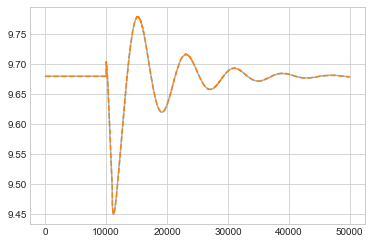

In [48]:
plt.plot(df.q.values, alpha=0.5)
plt.plot(pqs[:, 1], '--')

In [47]:
print(np.linalg.norm(df.p.values - pqs[:, 0]) / np.linalg.norm(df.p.values),
      np.linalg.norm(df.q.values - pqs[:, 1]) / np.linalg.norm(df.q.values),
      np.linalg.norm(df[['p', 'q']].values - pqs) / np.linalg.norm(df[['p', 'q']].values))

1.3013626056430666e-05 2.0098493310914605e-05 1.462567088937858e-05


## Testing learner

In [6]:
DIR = 'data_simple/std_params/R_e1'
injections = [os.path.join(DIR, fname) for fname in os.listdir(DIR)]

In [7]:
theta_true = np.array([1., 0.003, 0.3, 1.81, 1.76,
                       3.5, 0., 8., 10., 10., 0.05,
                       0.02, 0.015, 1., 1., 0.0001, 200])

In [37]:
lrn = Learner(injections, theta_true, stepsize=lambda k: 1/np.sqrt(k+1), eta=1e-1, mu=1)

[   0]	objective	2.137430e+07	distance to solution	1.995640e+02


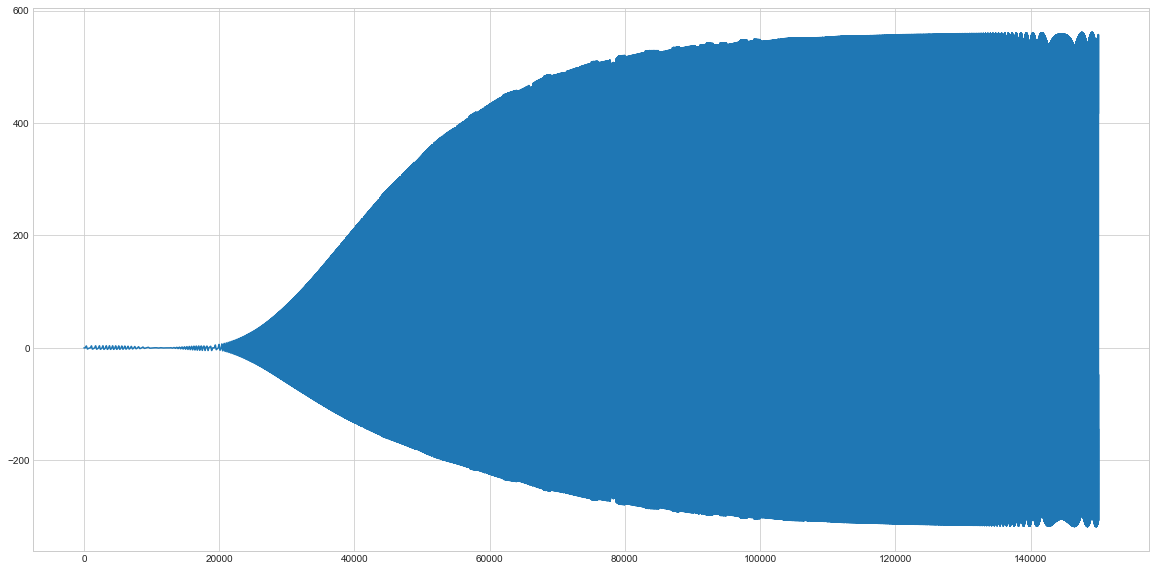

AssertionError: 

In [38]:
lrn.fit()

In [26]:
np.where(lrn.theta <= 0)[0]

(array([], dtype=int64),)

## Loss surface

In [52]:
from tqdm import tqdm_notebook

In [49]:
def objective(theta):
    x0, _, c, pq0 = get_initial_values(P0=1997.9999999936396,
                                       Q0=967.9249699065775,
                                       V0=1.0,
                                       angle0=0.494677176989154,
                                       theta0=theta)

    xs = [x0]
    pqs = [pq0]
    for t in range(1, len(df)):
        x, pq = transition(xs[-1], df[['v', 'phi']].values[t], c, theta)
        xs.append(x)
        pqs.append(pq)
    return 0.5 * np.mean(np.sum((pqs - df[['p', 'q']].values) ** 2, axis=1))

In [50]:
proj = np.random.randn(2, 17)

In [51]:
x = np.linspace(-10, 10)
xx, yy = np.meshgrid(x, x)

In [54]:
values = np.zeros((50, 50))
for i, (x, y) in enumerate(zip(tqdm_notebook(xx), yy)):
    thetas = np.stack([x, y]).T @ proj
    for j, theta in enumerate(thetas):
        values[i, j] = objective(theta)

HBox(children=(IntProgress(value=0, max=50), HTML(value='')))

KeyboardInterrupt: 

In [ ]:
sns.heatmap(np.log(values))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
xx, yy = np.meshgrid(np.linspace(-10, 10, 50), np.linspace(-10, 10, 50))
ax.plot_surface(xx, yy, np.clip(np.log(values), -1.5, 10), cmap=cm.coolwarm)
ax.view_init(30, -70)